In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

preprocessed_train_path = "C:\\Users\\fabio\\Downloads\\ETH\ML4H\Project\\Part 1\\preprocessed_heart_train_val.csv"
preprocessed_path = preprocessed_train_path.replace("\\" , "/")
df_train = pd.read_csv(preprocessed_path)
print(df_train)

preprocessed_test_path = "C:\\Users\\fabio\\Downloads\\ETH\ML4H\Project\\Part 1\\preprocessed_heart_test.csv"
preprocessed_test_path = preprocessed_path.replace("\\" , "/")
df_test = pd.read_csv(preprocessed_test_path)


      Age  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  Oldpeak  \
0    40.0      140.0        289.0        0.0  172.0             0.0      0.0   
1    37.0      130.0        283.0        0.0   98.0             0.0      0.0   
2    48.0      138.0        214.0        0.0  108.0             1.0      1.5   
3    54.0      150.0        195.0        0.0  122.0             0.0      0.0   
4    39.0      120.0        339.0        0.0  170.0             0.0      0.0   
..    ...        ...          ...        ...    ...             ...      ...   
729  41.0      120.0        157.0        0.0  182.0             0.0      0.0   
730  57.0      140.0        241.0        0.0  123.0             1.0      0.2   
731  45.0      110.0        264.0        0.0  132.0             0.0      1.2   
732  68.0      144.0        193.0        1.0  141.0             0.0      3.4   
733  57.0      130.0        131.0        0.0  115.0             1.0      1.2   

     HeartDisease  Female  ChestPainTyp

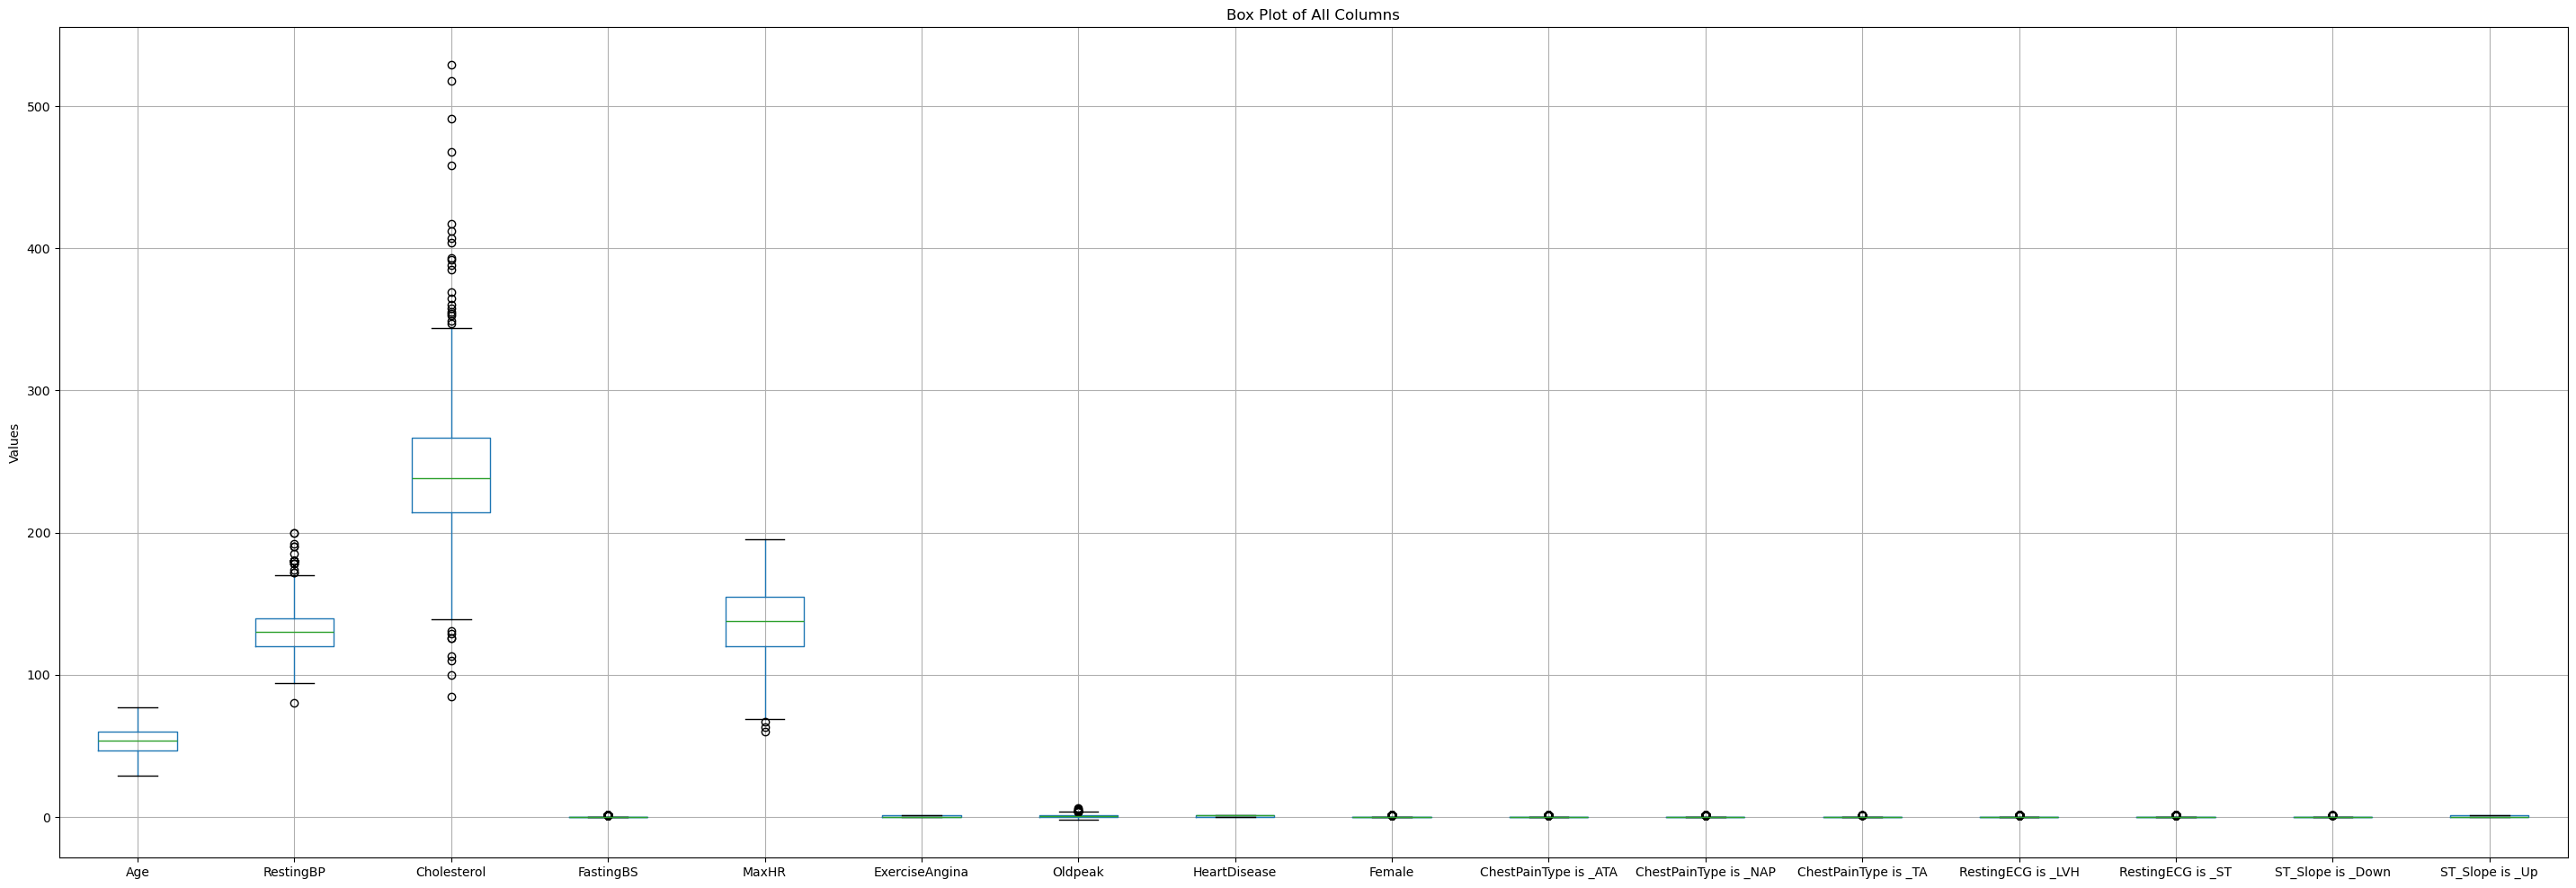

In [2]:
###Let's normalize data
##First, see if there are outliers

# Create a box plot of all columns
plt.figure(figsize=(36, 12))
df_train.boxplot()
plt.title('Box Plot of All Columns')
plt.ylabel('Values')
plt.grid(True)
plt.show()


In [3]:
#Separate features and target
X_train = df_train.drop(columns=['HeartDisease'])
X_test = df_test.drop(columns=['HeartDisease'])
y_train = df_train['HeartDisease']
y_test = df_test['HeartDisease']

#Since some vars are binary, to mantain consistency, lets apply minmax, not z-score
#And lets use normalization from train set
scaler = MinMaxScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [4]:
X_scaled_train.shape

(734, 15)

Let's do train/val split to find best alpha for Lasso

In [5]:
def negativeROCAUC(alpha,X_scaled_train,y_train):
        splits=10
        kf = KFold(n_splits=splits, shuffle=True, random_state=1)
        aucs = []

        for train_index, val_index in kf.split(X_scaled_train):
                # Split data into training and validation sets
                X_train_fold, X_val_fold = X_scaled_train[train_index], X_scaled_train[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                
                # Fit Lasso regression model
                lasso = Lasso(alpha=alpha)
                lasso.fit(X_train_fold, y_train_fold)
                
                # Predict probabilities on validation set
                y_prob_val = lasso.predict(X_val_fold)
                
                # Calculate AUC-ROC score
                auc_roc = roc_auc_score(y_val_fold, y_prob_val)
                aucs.append(auc_roc)

        # Calculate average AUC-ROC score across folds
        return-np.mean(aucs)

In [6]:
negativeROCAUC(0.1,X_scaled_train,y_train)

-0.8137335387694404

In [7]:
from scipy.optimize import minimize_scalar

# Use scipy.optimize to find optimal alpha that minimizes ROCAUC function
result = minimize_scalar(negativeROCAUC, bounds=(0.0000001,0.1),args=(X_scaled_train, y_train))

# Get optimal alpha value
optimal_alpha = result.x

print("Optimal Alpha:", optimal_alpha)

print(negativeROCAUC(result.x,X_scaled_train,y_train))


Optimal Alpha: 0.0007537829003194597
-0.9295700835983267


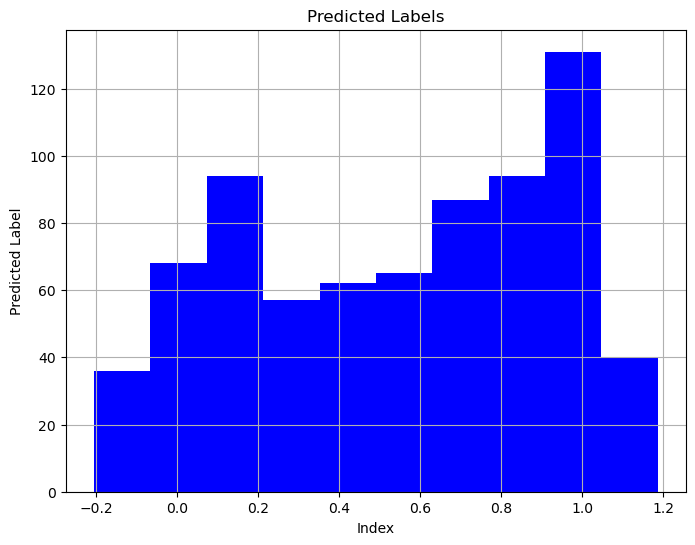

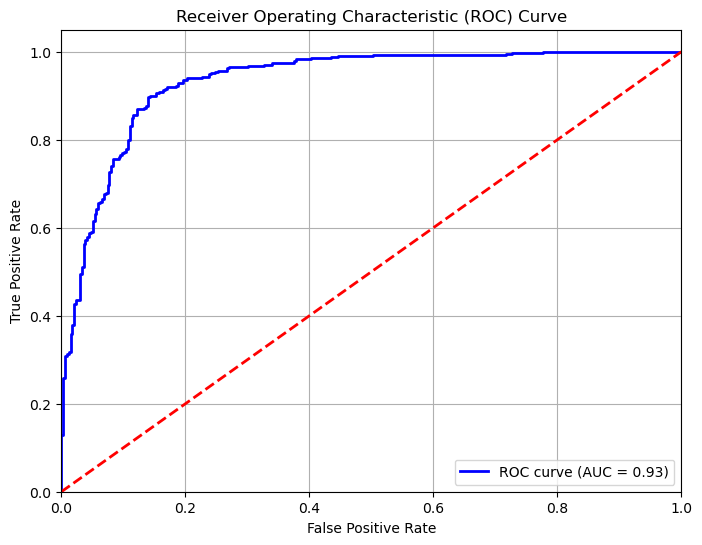

In [8]:
# Fit Lasso regression model
lasso = Lasso(alpha=optimal_alpha)
lasso.fit(X_scaled_train, y_train)

# Predict on test set
y_pred = lasso.predict(X_scaled_test)


# Plot predicted labels as 1D data points
plt.figure(figsize=(8, 6))
plt.hist(y_pred, color='b')
plt.title('Predicted Labels')
plt.xlabel('Index')
plt.ylabel('Predicted Label')
plt.grid(True)
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix

THRESHOLD=0.5
y_pred_rounded=y_pred>THRESHOLD

# Calculate balancede accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred_rounded)
print("Balanced Accuracy:", balanced_acc)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_rounded)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rounded)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Balanced Accuracy: 0.8763684493898062
F1 Score: 0.8899876390605687
Confusion Matrix:
[[285  51]
 [ 38 360]]
